In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

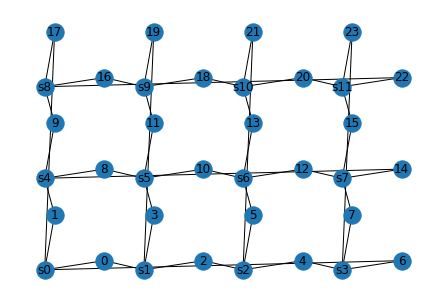

In [36]:
L = 2
r1 = 4
r2 = 3
N = 2*r1*r2 # number of data qubits
Ns = r1*r2 # number of stabilizers

Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(Sx,0)):
    qs = np.argwhere(Sx[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

# print(B_orig.nodes())

# pos = graphviz_layout(B_orig, prog='dot')

nx.draw(B_orig, pos,  with_labels=True)#, node_color = color_list)
plt.show()

logicals = np.zeros((2,2*r1*r2))
logicals[0,1:2*r1:2] = np.ones(r1) 
logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 



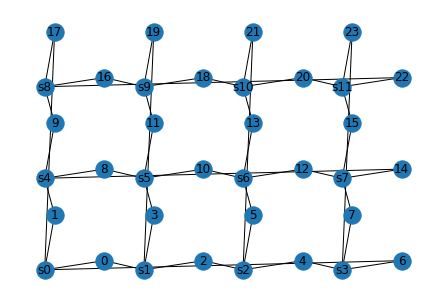

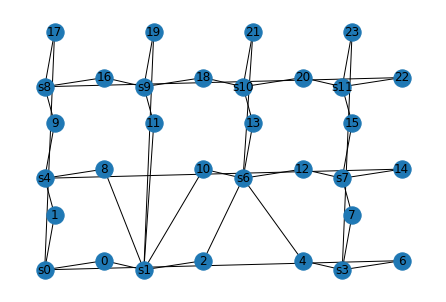

In [41]:
L = 2
r1 = 4
r2 = 3
N = 2*r1*r2 # number of data qubits
Ns = r1*r2 # number of stabilizers

Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(Sx,0)):
    qs = np.argwhere(Sx[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig, pos,  with_labels=True)#, node_color = color_list)
plt.show()

p = 0.3
loss_inds = [3,5]#np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
# print(loss_inds)

B = B_orig.copy()
s_nodes_set = set(np.copy(s_nodes))

Ns_remain = len(s_nodes_set)
q_remain = list(set(B.nodes())-s_nodes_set)
node_list = list(s_nodes_set) + q_remain
adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

logicals = np.zeros((2,2*r1*r2))
logicals[0,1:2*r1:2] = np.ones(r1) 
logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

logic_succ = True
for q in loss_inds:
    if Ns_remain == 0:
        break
    for i_log in range(np.size(logicals,0)):
        if logicals[i_log,q]>0:            
            st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
            if len(st_ind)>0:
                logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
            else:
                logic_succ = False
                break

    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}
        
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
            Sx_red = Sx_red[:,keep_cols]
            q_remain = np.array(q_remain)[keep_cols]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            
nx.draw(B, pos, with_labels=True)
plt.show()

## single layer

In [73]:
## with logical operator
L_list = np.arange(4,12,2)
p_list = np.linspace(0.01,0.99,20)
Nrep = 100
succ_prob = np.zeros((len(p_list),len(L_list)))
perc_prob = np.zeros((len(p_list),len(L_list)))
for i_L, L in enumerate(L_list):
    tic = time.time()
    
    r1 = L
    r2 = L
    N = 2*r1*r2 # number of data qubits
    Ns = r1*r2 # number of stabilizers

    Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
    pos = dict()
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
            pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
            pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
            pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
            pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
            pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])

            px, py = does_percolate_periodic(L,loss_inds)
            perc_val = ((px+py)>0)
            perc_prob[i_p,i_L] += perc_val
            
            B = B_orig.copy()
            s_nodes_set = set(np.copy(s_nodes))

            Ns_remain = len(s_nodes_set)
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
            Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

            logicals = np.zeros((2,2*r1*r2))
            logicals[0,1:2*r1:2] = np.ones(r1) 
            logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

            logic_succ = True
            for q in loss_inds:
                if Ns_remain == 0:
                    break
                for i_log in range(np.size(logicals,0)):
                    if logicals[i_log,q]>0:            
                        st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                        if len(st_ind)>0:
                            logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                        else:
                            logic_succ = False
                            break
                if not logic_succ:
                    break

                if q in B:
                    sq = [n for n in B.neighbors(q)]
                    if len(sq)==1:
                        B.remove_nodes_from(sq)
                        s_nodes_set -= set(sq)
                    elif len(sq)>1:
                        double_edgs = []
                        for i in range(len(sq)-1):
                            n0 = set(B.neighbors(sq[i]))
                            n1 = set(B.neighbors(sq[i+1]))
                            rep_qs = n0.intersection(n1)
                            q0 = list(set(n0)-rep_qs)
                            q1 = list(set(n1)-rep_qs)
                            double_edgs += [(sq[i], e) for e in q0]
                            double_edgs += [(sq[i], e) for e in q1]
                        G = nx.Graph()
                        G.add_nodes_from(sq[:-1])
                        G.add_edges_from(double_edgs)
                        sq_remain = list(s_nodes_set-set(sq))
                        for s in sq_remain:
                            G.add_edges_from([(s, e) for e in B.neighbors(s)])
                        B = G
                        s_nodes_set -= {sq[-1]}

                    Ns_remain = len(s_nodes_set)
                    if Ns_remain> 0:
                        q_remain = list(set(B.nodes())-s_nodes_set)
                        node_list = list(s_nodes_set) + q_remain
                        adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                        Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                        # keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
                        # Sx_red = Sx_red[:,keep_cols]
                        # q_remain = np.array(q_remain)[keep_cols]
                        Sx_mat = np.zeros((Ns_remain,N))
                        Sx_mat[:,q_remain] = Sx_red
                    else:
                        Sx_mat = []

            if Ns_remain > 0 and np.sum(np.sum(logicals,axis=1))>1 and logic_succ:
                succ_val = 1
                succ_prob[i_p,i_L] += succ_val
            else:
                succ_val = 0
                
            assert(succ_val == 1- perc_val)
    
    toc = time.time()
    print("finished L = %d in %.1f secs" % (L,toc-tic))

succ_prob /= Nrep
perc_prob /= Nrep

finished L = 4 in 8.7 secs
finished L = 6 in 30.6 secs
finished L = 8 in 83.6 secs
finished L = 10 in 193.6 secs


In [35]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    B = B_orig.copy()
    logicals = np.copy(logicals_in)
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set)
    q_remain = list(set(B.nodes())-s_nodes_set)
    node_list = list(s_nodes_set) + q_remain
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

    logic_succ = True
    for q in loss_inds:
        if logicals.ndim == 1:
            if logicals[q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals = (logicals+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in range(np.size(logicals,0)):
                if logicals[i_log,q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logic_succ = False
                        logicals[i_log,:] = np.zeros(np.size(logicals,1))
                        # break
            # if not logic_succ:
            #     break
            
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    if logicals.ndim == 1:
        logic_sum = np.sum(logicals)> 0
    else:
        # logic_sum = np.sum(np.sum(logicals,axis=1))> (np.size(logicals,0)-1)
        px = 0
        py = 0
        if np.sum(logicals[0,:])==0:
            py = 1
        if np.sum(logicals[1,:])==0:
            px = 1
    return px,py, (Ns_remain > 0), logicals, Sx_mat
    
#     succ_fail = 0
#     if Ns_remain > 0 and logic_sum and logic_succ:
#         succ_fail = 1

#     return succ_fail

In [61]:
## with logical operator
L_list = np.arange(4,12,2)
p_list = np.linspace(0.01,0.99,20)
Nrep = 100
succ_prob = np.zeros((len(p_list),len(L_list)))
perc_prob = np.zeros((len(p_list),len(L_list)))
for i_L, L in enumerate(L_list):
    tic = time.time()
    
    r1 = L
    r2 = L
    N = 2*r1*r2 # number of data qubits
    Ns = r1*r2 # number of stabilizers

    Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
    pos = dict()
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
            pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
            pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
            pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
            pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
            pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    logicals = np.zeros((2,2*r1*r2))
    logicals[0,1:2*r1:2] = np.ones(r1) 
    logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])

            px, py = does_percolate_periodic(L,loss_inds)
            perc_val = ((px+py)>0)
            perc_prob[i_p,i_L] += perc_val
            # print(px,py)
            
            # succ_val = succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            # succ_prob[i_p,i_L] += succ_val                
            # assert(succ_val == 1- perc_val)

            # px_s, py_s, stab = succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            px_s, py_s, stab, logic_red, Sx_stab = succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            succ_prob[i_p,i_L] += ((px_s+py_s)>0)
            # print("stab:", px_s,py_s, stab)
            assert(px==px_s and py==py_s)
    
    toc = time.time()
    print("finished L = %d in %.1f secs" % (L,toc-tic))

succ_prob /= Nrep
perc_prob /= Nrep

finished L = 4 in 9.0 secs
finished L = 6 in 31.7 secs
finished L = 8 in 85.8 secs
finished L = 10 in 201.7 secs


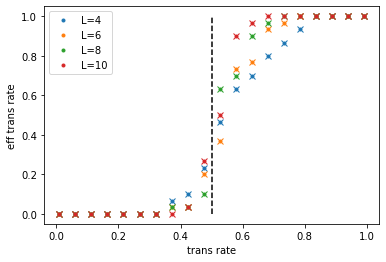

In [86]:
for i_L, L in enumerate(L_list):
    plt.plot(1-p_list,succ_prob[:,i_L],".", color ="C%d" % i_L, label="L=%d" % L)
    plt.plot(1-p_list,1-perc_prob[:,i_L],"x", color ="C%d" % i_L)

# plt.plot(1-p_list,1-p_list,"k--")
x0 = 0.5
plt.plot([x0,x0],[0,1],"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()

In [72]:
# square lattice
l = 2

def does_percolate_periodic(r1,r2,loss_inds):
    # r1 = r
    # r2 = r
    Gy = nx.Graph()
    Gy.add_nodes_from(np.arange(r1*(r2+1)))
    Gx = nx.Graph()
    Gx.add_nodes_from(np.arange((r1+1)*r2))

    for i2 in range(r2):
        for i1 in range(r1):
            ind1 = i2*r1+ i1
            ind2 = i2*r1 + ((i1+1)%r1)
            # cylinder along y
            if 2*ind1 in loss_inds:
                Gy.add_edge(ind1,ind2)
                if i2 ==0:
                    Gy.add_edge(r1*r2+ind1,r1*r2+ind2)
            if 2*ind1+1 in loss_inds:
                Gy.add_edge(ind1,ind1+r1)

            # cylinder along x
            ind2 = ((i2+1)%r2)*r1 + i1
            i2_g = ((i2+1)%r2)*(r1+1) + i1
            i1_g = i2*(r1+1)+ i1
            if 2*ind1+1 in loss_inds:
                Gx.add_edge(i1_g,i2_g)
                if i1 == 0 :
                    Gx.add_edge(i1_g+r1,i2_g+r1) 
            if 2*ind1 in loss_inds:
                Gx.add_edge(i1_g,i1_g+1)
                
    first_row = np.arange(r1)
    last_row = np.arange(r2*r1,(r2+1)*r1)
    path_y = 0
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(Gy,i_first,i_last):
                if (i_first - i_last )%r1 ==0:
                    path_y = 1
                    break

    first_col = np.arange(0,(r2-1)*(r1+1)+1,r1+1)
    last_col = np.arange(r1,r2*(r1+1)+1,r1+1)
    path_x = 0
    for i_first in first_col:
        for i_last in last_col:
            if nx.has_path(Gx,i_first,i_last):
                if int(i_first/(r1+1)) == int(i_last/(r1+1)):
                    path_x = 1
                    break
                    
    return path_x, path_y

def compute_eff_Sx(Sx,loss_inds,remain_inds):
            G_loss = nx.Graph()
            for loss_index in loss_inds:
                if loss_index%l ==0:
                    x2 = ((int(loss_index/2)%r1) +1 ) % r1
                    y2 = int(int(loss_index/2)/r1)
                else:
                    x2 = int(loss_index/2)%r1  
                    y2 = (int(int(loss_index/2)/r1)+1)%r2

                q2 = y2*r1 + x2
                G_loss.add_edge(int(loss_index/l),q2)

            components = [G_loss.subgraph(c).copy() for c in nx.connected_components(G_loss)]
            lost_vs = []
            for i_c, c in enumerate(components):
                lost_vs += c.nodes()

            remain_vs = list(set(range(r1*r2)) - set(lost_vs))
            num_stab = len(components)+len(remain_vs)
            Sx_red2 = np.zeros((num_stab,len(remain_inds)))
            Sx_red2[len(components):,:] = Sx[np.ix_(remain_vs,remain_inds)]
            for i_c, c in enumerate(components):
                Sx_red2[i_c,:] = np.sum(Sx[np.ix_(c.nodes(),remain_inds)],axis = 0)%2

            keep_cols = np.argwhere(np.sum(Sx_red2,axis=0)>0)[:,0]
            Sx_red2 = Sx_red2[:,keep_cols]
            qubits_to_plot = remain_inds[keep_cols]

            return Sx_red2, qubits_to_plot

# L_list = np.arange(4,12,2)
# p_list = np.linspace(0.01,0.99,20)

# Nrep = 100
# prob = np.zeros((len(L_list),len(p_list)))
# tic = time.time()
# for i_L, L in enumerate(L_list):
#     print(L)
#     for i_r in range(Nrep):
#         for i_p, prob_l in enumerate(p_list):
#             # loss error
#             error_loss = np.random.rand(l* (L**2)) 
#             loss_inds = np.argwhere(error_loss < prob_l)[:,0]
#             # remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
            
#             px, py = does_percolate_periodic(L,loss_inds)
#             prob[i_L,i_p] += ((px+py)>0)
# toc = time.time()
# print("time = ", toc-tic, "secs")
# prob /= Nrep

## sanity check

stab: 1 0 True


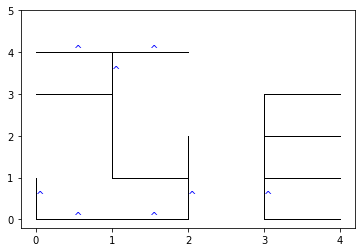

In [69]:
l = 2
r1 = 4
r2 = 5
N = 2*r1*r2
Ns = r1*r2

Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

# # loss error
prob_l = 0.4 # loss error probability
error_loss = np.random.rand(l*r1*r2) 
loss_inds = np.argwhere(error_loss < prob_l)[:,0]
remain_inds = list(set(np.arange(N))-set(loss_inds))#np.argwhere(error_loss >= prob_l)[:,0]
error_loss[loss_inds] = 1
error_loss[remain_inds] = 0

plt.figure(1)
# for i in range(len(qubits_to_plot)):
#     latt_pos = int(qubits_to_plot[i]/2)
for link in remain_inds:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)

#################################

B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(Sx,0)):
    qs = np.argwhere(Sx[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

logicals_in = np.zeros((2,2*r1*r2))
logicals_in[0,1:2*r1:2] = np.ones(r1) 
logicals_in[1,0:2*r1*r2:2*r1] = np.ones(r2) 

px_s, py_s, stab, logic_red, Sx_stab = succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds)
print("stab:", px_s,py_s, stab)

# inds_logic_h = np.argwhere(logic_red[0,qubits_to_plot] > 0 )[:,0]
# for link in qubits_to_plot[inds_logic_h]:
inds_logic_h = np.argwhere(logic_red[0,:] > 0 )[:,0]
for link in inds_logic_h:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"^",color="b")
    

# inds_logic_v = np.argwhere(logic_red[1,qubits_to_plot] > 0 )[:,0]
# for link in qubits_to_plot[inds_logic_v]:
inds_logic_v = np.argwhere(logic_red[1,:] > 0 )[:,0]
for link in inds_logic_v:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"v",color="r")
    

# px, py = does_percolate_periodic(r1,loss_inds)
# perc_val = ((px+py)>0)
# print(px,py)


#################################
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()

# nx.draw(B_orig, pos,  with_labels=True)#, node_color = color_list)
# plt.show()

rep: 99
0 0
stab: 0 0 True
succ ratio: 35


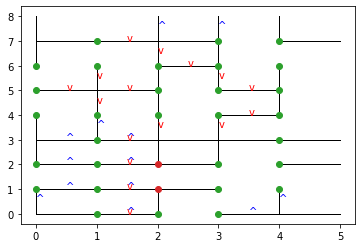

In [75]:
l = 2
r1 = 5
r2 = 8
N = 2*r1*r2
Ns = r1*r2

Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

# # loss error
prob_l = 0.48 # loss error probability
Nrep = 100
succ_prob = 0
for i_rep in range(Nrep):
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = list(set(np.arange(N))-set(loss_inds))#np.argwhere(error_loss >= prob_l)[:,0]
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    plt.figure(1)
    plt.cla()
    # for i in range(len(qubits_to_plot)):
    #     latt_pos = int(qubits_to_plot[i]/2)
    for link in remain_inds:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) 
            plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
        else:
            ry = int(latt_pos/r1)  
            rx = (latt_pos%r1)   
            plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        ## possibly more efficient
        if loss_index%2 ==0:
            q2 = int(int(loss_index/2)/r1)*r1 + ((int(loss_index/2)%r1+1)%r1)
        else:
            q2 = ((int(int(loss_index/2)/r1)+1)%r2)*r1 + (int(loss_index/2)%r1)
        star_ops = np.array([int(loss_index/2),q2])
        st_ind2 = star_ops[np.argwhere(Sx_old[np.ix_(star_ops),loss_index]>0)]
        st_ind2 = list(np.sort(st_ind2[:,1]))
        if not np.array_equal(st_ind2,st_ind):
            print(st_ind,st_ind2)

        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    # plt.cla()
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    #################################

    N = 2*r1*r2
    Ns = r1*r2
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    logicals_in = np.zeros((2,2*r1*r2))
    logicals_in[0,1:2*r1:2] = np.ones(r1) 
    logicals_in[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    px_s, py_s, stab, logic_red, Sx_stab = succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds)
    # print("stab:", px_s,py_s, stab)
    succ_prob += (1-px_s)*(1-py_s)
    
    # inds_logic_h = np.argwhere(logic_red[0,qubits_to_plot] > 0 )[:,0]
    # for link in qubits_to_plot[inds_logic_h]:
    inds_logic_h = np.argwhere(logic_red[0,:] > 0 )[:,0]
    for link in inds_logic_h:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"^",color="b")


    # inds_logic_v = np.argwhere(logic_red[1,qubits_to_plot] > 0 )[:,0]
    # for link in qubits_to_plot[inds_logic_v]:
    inds_logic_v = np.argwhere(logic_red[1,:] > 0 )[:,0]
    for link in inds_logic_v:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"v",color="r")


    px, py = does_percolate_periodic(r1,r2,loss_inds)
    # perc_val = ((px+py)>0)
    # print(px,py)


    #################################
    if not (px==px_s and py==py_s):
        break
    # assert(px==px_s and py==py_s)

print("rep:", i_rep)
print(px,py)
print("stab:", px_s,py_s, stab)
print("succ ratio:", succ_prob)

plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()



## multi layer

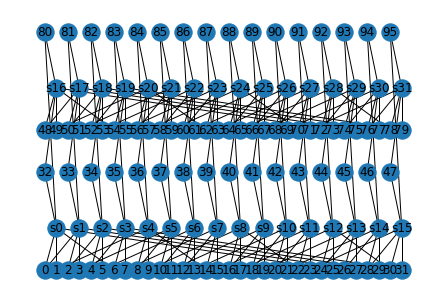

finished L = 2 in 13.0 secs


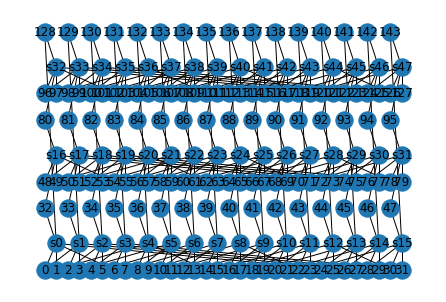

finished L = 3 in 27.8 secs


In [68]:
r1 = 4
r2 = 4

# in layer stabilizer group
Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        # pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        # pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        # pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        # pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        # pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

logicals_l = np.zeros((2,2*r1*r2))
logicals_l[0,1:2*r1:2] = np.ones(r1) 
logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

Nl_list = np.arange(2,4)
p_list = np.linspace(0.01,0.4,20)
Nrep = 50
succ_prob = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    # pos = graphviz_layout(B_orig, prog="dot")
    pos = dict()
    for q in range(N):
        x_l = q%(Nq_l+Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(q/(Nq_l+Ns_l))
        if x_l >= Nq_l:
            pos[q] = (2*(x_l-Nq_l/2)-Nq_l,z+0.7)
            # pos[q] = (x,y,z)
        else:
            pos[q] = (x_l,z)
    for sq in range(Ns):
        x_l = (sq% Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x_l+1,z+0.3)

    # pos  = nx.spring_layout(B_orig, k = 0.5)
    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()

    logicals = np.zeros((2,N))
    for i_l in range(Nl):
        logicals[:2,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l
    # logicals[
    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            # succ_prob[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            px_s, py_s, stab, logic_red, Sx_stab = succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            succ_prob[i_p,i_L] += (1-px_s)*(1-py_s)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob /= Nrep

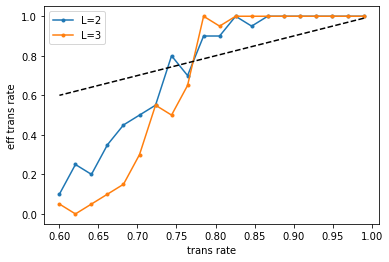

In [67]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob[:,i_L],".-", color ="C%d" % i_L, label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()